In [1]:
!gdown --id 1VGXQ18-7h7cSru-IwIolPTe8603uOiKd

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1VGXQ18-7h7cSru-IwIolPTe8603uOiKd
To: /content/data_compare_feature.csv
100% 6.90M/6.90M [00:00<00:00, 30.1MB/s]


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
df = pd.read_csv('data_compare_feature.csv')

In [4]:
df.head()

,time,user_id,event,hotel_id,sum_usd,n_days
0,04:34:58,288941,open_hotel,37183566,NaN,NaN
1,04:34:58,288941,open_hotel,37183566,NaN,NaN
2,04:35:29,288941,open_hotel,37183566,NaN,NaN
3,04:35:30,288941,open_hotel,37183566,NaN,NaN
4,14:05:53,234057,open_hotel,21723277,NaN,NaN


In [5]:
df.event.value_counts()

,count
event,
open_hotel,134829
book,9392
open_compare,3592


In [6]:
df.user_id.nunique()

34110

Из 34110 юзеров забронировали отель 9392. Воспользовались новой функцией 3592.


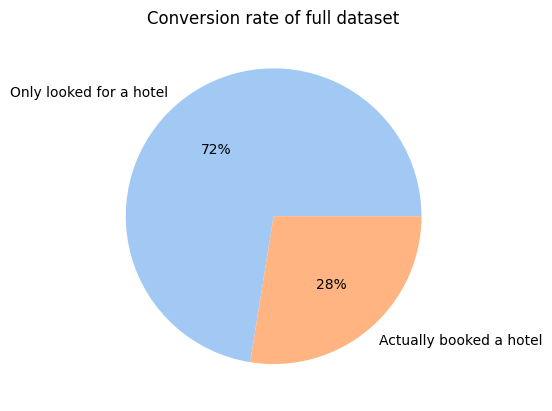

In [24]:
data = [df.user_id.nunique()-df[df['event']=='book'].shape[0],df[df['event']=='book'].shape[0]]
labels = ['Only looked for a hotel', 'Actually booked a hotel']
colors = sns.color_palette('pastel')[ 0:5 ]
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.title('Conversion rate of full dataset')
plt.show()

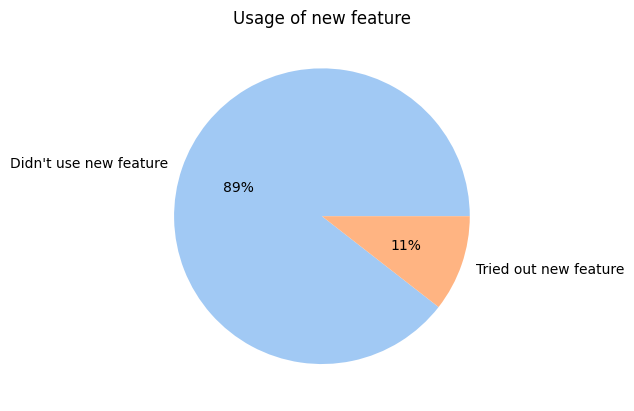

In [8]:
data = [df.user_id.nunique()-df[df['event']=='open_compare'].shape[0],df[df['event']=='open_compare'].shape[0]]
labels = ['Didn\'t use new feature', 'Tried out new feature']

plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.title('Usage of new feature')
plt.show()

Найдем кол-во юзеров, которые забронировали отель после использования новой фичи:

In [9]:
# отфильтруем логи, в которых юзеры открывали страницу отеля
filtered_df = df[df['event'].isin(['open_compare', 'book'])]

# сортировка полученного датасета по времени, чтобы убедиться, что бронирование произошло после использования новой фичи
filtered_df = filtered_df.sort_values(by= 'time')

# словарь для создания меток у юзеров, которые забронировали отель после сравнения
book_counts = {}

for user_id, user_df in filtered_df.groupby('user_id'):
    # поиск первого использования фичи
    try:
        first_open_compare_time = user_df[user_df['event'] == 'open_compare']['time'].iloc[0]
    except IndexError:
        # если юзер не использовал фичу, он пропускается
        continue

    # подсчет бронирований после сравнения
    book_after_open_compare = user_df[(user_df['event'] == 'book') & (user_df['time'] > first_open_compare_time)]
    book_count = book_after_open_compare.shape[0]
    book_counts[user_id] = book_count

# приведем словарь к датафрейму
result_df = pd.DataFrame(list(book_counts.items()), columns=['user_id', 'book_count_after_open_compare'])

result_df

,user_id,book_count_after_open_compare
0,100037,1
1,100059,1
2,100395,1
3,100614,1
4,100704,0
...,...,...
3587,999518,1
3588,999630,1
3589,999703,1
3590,999739,1


Посмотрим, сколько юзеров действительно забронировали отель после использования новой фичи:

In [10]:
result_df['book_count_after_open_compare'].value_counts()

,count
book_count_after_open_compare,
1,2681
0,911


In [21]:
# создадим список с юзерами, которые забронировали отель после сравнения отелей
users_booked_after_compare = list(result_df[result_df['book_count_after_open_compare'] == 1]['user_id'])

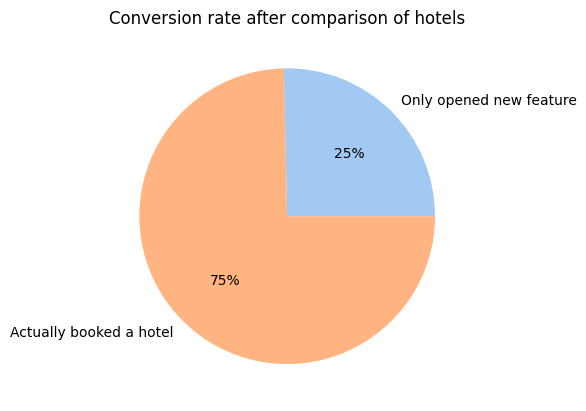

In [23]:
data = [df[df['event']=='open_compare'].shape[0]-len(users_booked_after_compare), len(users_booked_after_compare)]
labels = ['Only opened new feature','Actually booked a hotel']
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.title('Conversion rate after comparison of hotels')
plt.show()

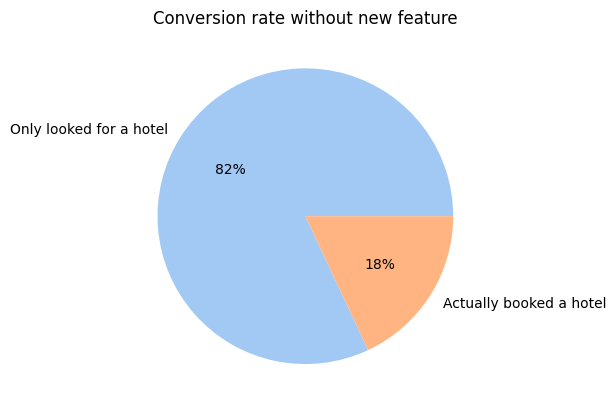

In [26]:
data = [df.user_id.nunique()-df[df['event']=='open_compare'].shape[0], df[df['event']=='book'].shape[0]-len(users_booked_after_compare)]
labels = ['Only looked for a hotel','Actually booked a hotel']
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.title('Conversion rate without new feature')
plt.show()

На графиках можно увидеть, что конверсия всего датасета составила 28%. Новую фичу испробовали лишь 11% пользователей, однако из этих 11% 75% процентов действительно забонировали отель. Такой показатель более чем в три раза выше, чем конверсия пользователей, не воспользовавшихся новой функцией сравнения отелей.

Результат достаточно убедительный, чтобы вкладываться в развитие и маркетинг данной функции.

Далее можно посмотреть, отличается ли средняя цена отелей, забронированных после сравнения от отелеЙ, которые были выбраны без использования новой функции.

В качестве уровня значимости зададим значение 5%.

In [27]:
# создадим список цен на отели, которые забронированы с новой фичей
hotels_with = list(df[df['user_id'].isin(users_booked_after_compare)]['sum_usd'].dropna())

In [28]:
#список цен на отели, забронированные без фичи
hotels_without = list(df[~df['user_id'].isin(users_booked_after_compare)]['sum_usd'].dropna())

Text(0.5, 1.0, 'Распределение цен на отели забронированные с использованием новой функции')

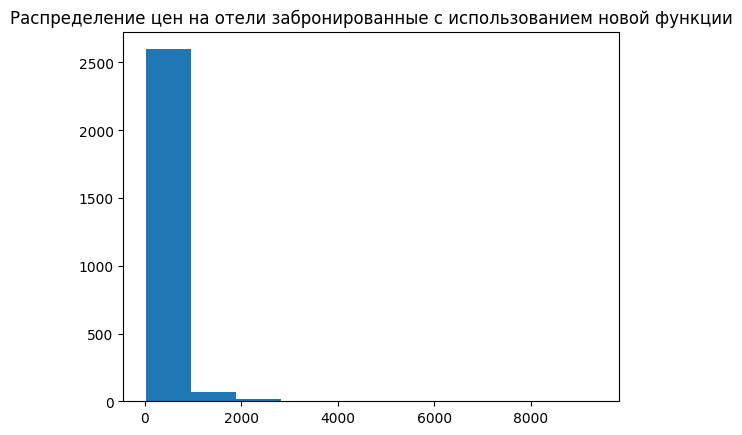

In [33]:
plt.hist(hotels_with)
plt.title('Распределение цен на отели забронированные с использованием новой функции')

Text(0.5, 1.0, 'Распределение цен на отели забронированные без использования новой функции')

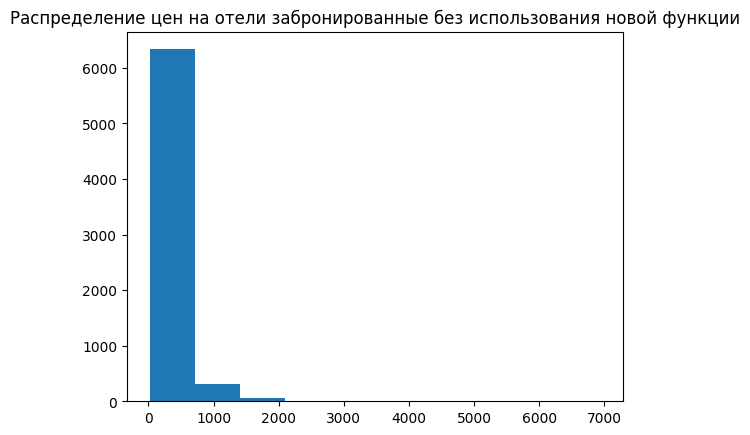

In [34]:
plt.hist(hotels_without)
plt.title('Распределение цен на отели забронированные без использования новой функции')

Исходя из графиков распределений цен на отели видно, что для сравнения средних выборок нельзя использовать t-test. Так как распределение не нормальное, нужно использовать тест Манна-Уитни.

In [35]:
import scipy. stats as stats
stats.mannwhitneyu(hotels_with,hotels_without,alternative='greater')


MannwhitneyuResult(statistic=9103051.5, pvalue=0.183724412527006)

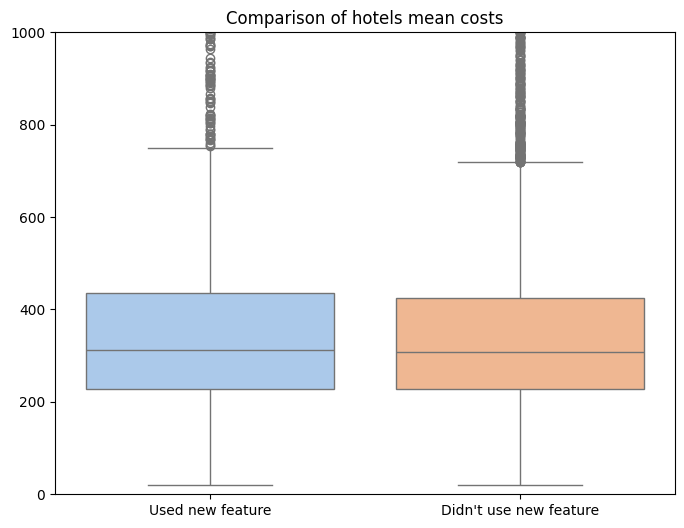

In [36]:
data = [hotels_with,hotels_without]
labels = ['Used new feature','Didn\'t use new feature']
plt.figure(figsize=(8, 6))

# Построение боксплотов
sns.boxplot(data=data,palette = 'pastel')

# Установка имен на оси x
plt.xticks(ticks=[0, 1], labels=labels)

# Название графика
plt.title('Comparison of hotels mean costs')
plt.ylim(0,1000)
# Отображение графика
plt.show()

P-value составляет 18%, что превышает заданный уровень значимости, из чего можно сделать что статистической разницы между средней стоимостью отелей нет.